# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [9]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import itertools
from nltk import ngrams
from wordcloud import WordCloud
import pickle

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [10]:
#loading train and test and validation dataset

file=open("x_train.pkl","rb")
x_train=pickle.load(file) # loading 'train' dataset

file=open("x_cv.pkl",'rb')
x_cv=pickle.load(file) # loading 'validation' dataset

file=open("x_test.pkl",'rb')
x_test=pickle.load(file) # loading 'test' dataset

file=open("y_train.pkl","rb")
y_train=pickle.load(file) # loading 'train' dataset

file=open("y_cv.pkl",'rb')
y_cv=pickle.load(file) # loading 'validation' dataset

file=open("y_test.pkl",'rb')
y_test=pickle.load(file) # loading 'test' dataset

#loading train_bow and test _bow
file=open('x_train_bow.pkl','rb')
x_train_bow=pickle.load(file)

file=open('x_test_bow.pkl','rb')
x_test_bow=pickle.load(file)

file=open('x_cv_bow.pkl','rb')
x_cv_bow=pickle.load(file)

#loading train_tf_idf and test_tf_idf
file=open('train_tf_idf.pkl','rb')
train_tf_idf=pickle.load(file)

file=open('cv_tf_idf.pkl','rb')
cv_tf_idf=pickle.load(file)

file=open('test_tf_idf.pkl','rb')
test_tf_idf=pickle.load(file)

#loading train_w2v and test_w2v
file=open('train_w2v.pkl','rb')
train_w2v=pickle.load(file)

file=open('cv_w2v.pkl','rb')
cv_w2v=pickle.load(file)

file=open('test_w2v.pkl','rb')
test_w2v=pickle.load(file)

#loading train_tf_idf_w2v and test_tf_idf_w2v
file=open('train_tf_idf_w2v.pkl','rb')
train_tf_idf_w2v=pickle.load(file)

file=open('cv_tf_idf_w2v.pkl','rb')
cv_tf_idf_w2v=pickle.load(file)

file=open('test_tf_idf_w2v.pkl','rb')
test_tf_idf_w2v=pickle.load(file)

# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [14]:
# Using tfidf for choosing top 20000 feature to make  co-occurance matrix

tf=TfidfVectorizer(ngram_range=(1,1),max_features=2000)
temp=tf.fit(x_train)
vocab = tf.get_feature_names()


### [5.2] Calulation of Co-occurrence matrix

#### steps to find co-occurance matrix

1. find vocabulary using tfidf or bow (Can limit max_features for computational strain eg, max_feature=20000)


2. make a dict of vocabluary named vocab


2. make psudo/zero matrix of shape(len(vocab),len(vocab)) named co_occurrence_matrix


3. for each reviews/sentence in traing data, make a contetx window of size k ( I am using nltk.ngram for making context window of default k=2)


4. Update the co_occurance_matrix using context window of each reviews



In [11]:
# generarting d*d co_occurance matrix (d = vocabulary size)
# refer: https://www.pythonprogramming.in/how-to-calculate-a-word-word-co-occurrence-matrix.html

def generate_co_occurance_matrix(data, vocab, contex_window_size=2):
       
    vocab = list(set(vocab))
    vocab_index = {word: i for i, word in enumerate(vocab)}
    
    co_occurnce_matrix=np.zeros((len(vocab),len(vocab))) # creating d*d matrix

    for text in data:  
        n_grams_tuples = ngrams(str(text).split(), contex_window_size+1)

        for gram in n_grams_tuples:
            for i in gram:
                for j in gram:
                    if j!=i and i in vocab and j in vocab:
                        w_i=vocab_index[i]
                        w_j=vocab_index[j]
                        co_occurnce_matrix[w_i][w_j] +=1
                                               
    return co_occurnce_matrix, vocab_index

In [1]:
import numpy as np
import pandas as pd

def create_cooccurrence_matrix(sentences, window_size=2):

    import scipy
    import nltk

    vocabulary = {}
    data = []
    row = []
    col = []

    tokenizer = nltk.tokenize.word_tokenize

    for sentence in sentences:
        sentence = sentence.strip()
        tokens = [token for token in tokenizer(sentence) if token != u""]
        for pos, token in enumerate(tokens):
            i = vocabulary.setdefault(token, len(vocabulary))
            start = max(0, pos-window_size)
            end = min(len(tokens), pos+window_size+1)
            for pos2 in range(start, end):
                if pos2 == pos:
                    continue
                j = vocabulary.setdefault(tokens[pos2], len(vocabulary))
                data.append(1.)
                row.append(i)
                col.append(j)

    cooccurrence_matrix_sparse = scipy.sparse.coo_matrix((data, (row, col)))
    return vocabulary, cooccurrence_matrix_sparse

In [3]:
data=["abc def ijk pqr","pqr klm opq","lmn pqr xyz abc def pqr abc"] 

In [5]:
v,c=create_cooccurrence_matrix(data, window_size=2)

In [11]:
data = x_train #reviews
v,c=create_cooccurrence_matrix(data, window_size=2)

In [7]:
c.todense()

matrix([[0., 3., 1., 3., 0., 0., 0., 1.],
        [3., 0., 1., 2., 0., 0., 0., 1.],
        [1., 1., 0., 1., 0., 0., 0., 0.],
        [3., 2., 1., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 1., 0., 1., 0., 0., 1., 0.]])

In [25]:
# toy dataset
data=["abc def ijk pqr","pqr klm opq","lmn pqr xyz abc def pqr abc"] 

# limiting max_feature=3
tf=TfidfVectorizer(ngram_range=(1,1),max_features=3)
tf.fit(data)
vocab = tf.get_feature_names()

matrix, vocab_index = generate_co_occurance_matrix(data, vocab, contex_window_size=3)
data_matrix = pd.DataFrame(matrix, index=vocab_index,
                             columns=vocab_index)
data_matrix

,pqr,def,abc
pqr,0.0,4.0,6.0
def,4.0,0.0,5.0
abc,6.0,5.0,0.0


In [24]:
data=["abc def ijk pqr", "pqr klm opq", "lmn pqr xyz abc def pqr abc"]
for text in data:  
        n_grams_tuples = ngrams(str(text).split(), 2+1)

        for gram in n_grams_tuples:
            print(gram)

('abc', 'def', 'ijk')
('def', 'ijk', 'pqr')
('pqr', 'klm', 'opq')
('lmn', 'pqr', 'xyz')
('pqr', 'xyz', 'abc')
('xyz', 'abc', 'def')
('abc', 'def', 'pqr')
('def', 'pqr', 'abc')


In [20]:
# toy dataset
data=["abc def ijk pqr","pqr klm opq","lmn pqr xyz abc def pqr abc"] 

# limiting max_feature=200
tf=TfidfVectorizer(ngram_range=(1,1),max_features=200)
tf.fit(data)
vocab = tf.get_feature_names()

matrix, vocab_index = generate_co_occurance_matrix(data, vocab, contex_window_size=3)
data_matrix = pd.DataFrame(matrix, index=vocab_index,
                             columns=vocab_index)

data_matrix

,klm,def,pqr,opq,abc,ijk,xyz,lmn
klm,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
def,0.0,0.0,3.0,0.0,4.0,2.0,1.0,0.0
pqr,1.0,3.0,0.0,1.0,3.0,1.0,2.0,1.0
opq,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
abc,0.0,4.0,3.0,0.0,0.0,1.0,2.0,0.0
ijk,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0
xyz,0.0,1.0,2.0,0.0,2.0,0.0,0.0,1.0
lmn,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [16]:

data = x_train #reviews

# creating vocabulary of top 2000 words
tf=TfidfVectorizer(ngram_range=(1,1)) # limiting vocab sizes using max_features parameter
tf.fit(data)
vocab = tf.get_feature_names() 


In [23]:
tf.idf_

array([ 9.73668207, 10.34759115, 11.90573577, ..., 12.59888295,
       12.59888295, 12.59888295])

In [ ]:
tf.

In [16]:
# reviews dataset

data = x_train #reviews

# creating vocabulary of top 2000 words
tf=TfidfVectorizer(ngram_range=(1,1),max_features=2000) # limiting vocab sizes using max_features parameter
tf.fit(data)
vocab = tf.get_feature_names() 

matrix, vocab_index = generate_co_occurance_matrix(data, vocab, contex_window_size=3)
data_matrix = pd.DataFrame(matrix, index = vocab_index,
                             columns = vocab_index)
data_matrix

,disappointment,opened,reduced,called,imagine,simply,costs,dressing,content,house,...,lot,let,egg,jerky,mio,selection,freshly,son,middle,firm
disappointment,0.0,12.0,1.0,2.0,18.0,4.0,1.0,0.0,0.0,1.0,...,3.0,4.0,0.0,4.0,0.0,0.0,0.0,2.0,1.0,0.0
opened,12.0,0.0,0.0,7.0,15.0,9.0,0.0,2.0,0.0,10.0,...,10.0,10.0,3.0,1.0,3.0,0.0,60.0,9.0,2.0,0.0
reduced,1.0,0.0,0.0,3.0,1.0,7.0,0.0,1.0,12.0,0.0,...,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
called,2.0,7.0,3.0,0.0,3.0,13.0,0.0,4.0,0.0,15.0,...,13.0,22.0,4.0,1.0,2.0,1.0,0.0,5.0,0.0,0.0
imagine,18.0,15.0,1.0,3.0,0.0,7.0,1.0,0.0,0.0,1.0,...,12.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0
simply,4.0,9.0,7.0,13.0,7.0,0.0,1.0,1.0,4.0,6.0,...,8.0,11.0,3.0,16.0,1.0,3.0,0.0,4.0,1.0,2.0
costs,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,58.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
dressing,0.0,2.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,14.0,...,7.0,4.0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0
content,0.0,0.0,12.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,...,8.0,8.0,0.0,4.0,0.0,0.0,1.0,2.0,1.0,1.0
house,1.0,10.0,0.0,15.0,1.0,6.0,0.0,14.0,3.0,0.0,...,44.0,15.0,1.0,1.0,1.0,2.0,1.0,15.0,1.0,0.0


In [21]:
# saving file using pickle

"""file= open("datamatrix.pkl","wb")
pickle.dump(data_matrix,file)
file.close()

file= open("vocab_index.pkl","wb")
pickle.dump(data_matrix,file)
file.close()"""

file= open("vocab_index.pkl","rb")
vocab_index=pickle.load(file)
file.close()

file= open("datamatrix.pkl","rb")
data_matrix=pickle.load(file)
file.close()

In [22]:
data_matrix.shape

(2000, 2000)

In [23]:
# normalise 
from sklearn.preprocessing import normalize
data_matrix=normalize(data_matrix)

### [5.3] Finding optimal value for number of components (n) to be retained.

In [24]:
# applying SVD to find the optimum number of (n)
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=data_matrix.shape[1]-1)
svd.fit(data_matrix)

TruncatedSVD(algorithm='randomized', n_components=1999, n_iter=5,
             random_state=None, tol=0.0)

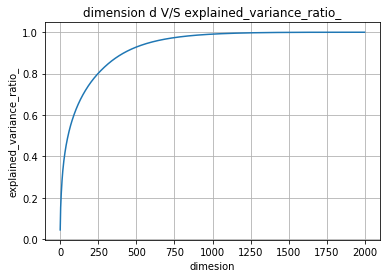

In [25]:
plt.plot(range(data_matrix.shape[1]-1),np.cumsum(svd.explained_variance_ratio_))
plt.title("dimension d V/S explained_variance_ratio_")
plt.xlabel("dimesion")
plt.ylabel("explained_variance_ratio_")
plt.grid()
plt.show()

Optimum n = 500


Able to explain 90 % variance

In [26]:
# applying SVD tusing optimum d=500
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=500)
svd_w2v=svd.fit_transform(data_matrix)

In [27]:
# creating datafram od SVD_W2V
df={}
for idx,word in enumerate(list(vocab_index.keys())):
                          df.update({word:svd_w2v[idx]})

w2v_df=pd.DataFrame(df)
w2v_df=w2v_df.T
w2v_df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
disappointment,0.712931,0.191733,0.057307,0.125301,-0.021329,-0.039025,-0.005084,0.011807,0.008322,0.027429,...,-0.009026,-0.000698,0.002276,-0.015374,0.009339,0.001013,0.015250,-0.012360,0.013260,-0.015290
opened,0.457779,0.016596,-0.242161,-0.021469,0.177105,-0.226595,-0.116571,-0.153807,-0.060226,0.138350,...,-0.002013,-0.010003,-0.023591,0.003308,-0.009410,-0.000376,0.004541,0.026505,-0.032896,0.026107
reduced,0.373104,-0.070254,-0.093158,-0.002931,-0.064667,-0.223998,0.155453,0.185059,-0.030036,0.081042,...,-0.012734,0.001800,0.001417,-0.007517,0.008048,-0.014857,-0.004484,0.008665,-0.001005,-0.007882
called,0.682947,-0.039661,-0.175691,0.141051,-0.059906,-0.073311,0.039717,0.112816,-0.056235,-0.090811,...,-0.000032,-0.013224,-0.000861,-0.016220,-0.008852,-0.015202,0.001970,-0.000859,-0.000296,0.009786
imagine,0.755733,0.443094,0.155179,0.036594,0.045108,0.059885,0.002274,-0.074600,0.038562,-0.074619,...,0.003252,-0.000885,0.003217,0.008673,0.006609,0.004393,0.005564,0.003920,-0.002357,0.013695


In [28]:
# sample
w2v_df.iloc[0]

0      0.712931
1      0.191733
2      0.057307
3      0.125301
4     -0.021329
5     -0.039025
6     -0.005084
7      0.011807
8      0.008322
9      0.027429
10     0.048500
11    -0.096708
12     0.032934
13    -0.025200
14     0.002230
15    -0.022927
16     0.003206
17    -0.022277
18     0.020679
19    -0.034746
20     0.066385
21     0.022889
22    -0.025550
23    -0.019752
24     0.023392
25    -0.022894
26    -0.008462
27    -0.063218
28    -0.018106
29    -0.019294
         ...   
470    0.000603
471    0.007042
472    0.004011
473    0.002434
474    0.026238
475    0.000167
476    0.001341
477   -0.002075
478   -0.007050
479    0.011020
480   -0.003010
481   -0.018547
482   -0.005448
483    0.001560
484    0.013382
485    0.003161
486    0.000830
487   -0.000545
488   -0.006900
489    0.004752
490   -0.009026
491   -0.000698
492    0.002276
493   -0.015374
494    0.009339
495    0.001013
496    0.015250
497   -0.012360
498    0.013260
499   -0.015290
Name: disappointment, Le

### [5.4] Applying k-means clustering

In [392]:
from sklearn.cluster import k_means
from sklearn.metrics import silhouette_score
k=[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
inertia=[]
ss=[]

for i in k:
    km=KMeans(n_clusters=i)
    km.fit(w2v_df)
    inertia.append(km.inertia_)
    ss.append(silhouette_score(w2v_df,km.predict(w2v_df))) 

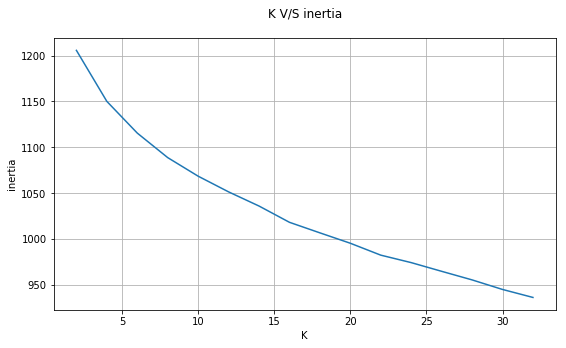

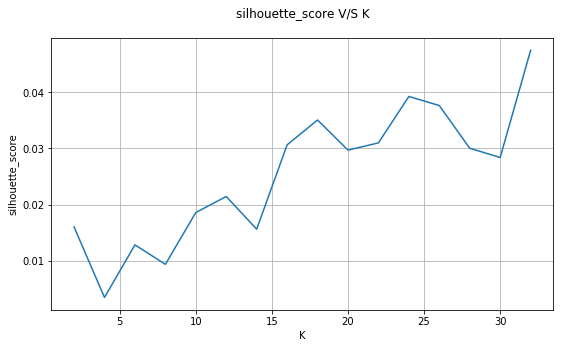

In [395]:
# ploting K(n_cluster) V/S score
plt.figure(figsize=(9,5))
plt.plot(k,inertia)
plt.title("K V/S inertia\n")
plt.xlabel("K")
plt.ylabel("inertia")
plt.grid()
plt.show()

plt.figure(figsize=(9,5))
plt.plot(k,ss)
plt.title("silhouette_score V/S K\n")
plt.xlabel("K")
plt.ylabel("silhouette_score")
plt.grid()
plt.show()

### Optimal number of cluser K = 3 

In [53]:
optimal_k=4
km=KMeans(n_clusters=optimal_k)
km.fit(w2v_df)
print("inertia: ",km.inertia_)
print("silhouette_score: ",silhouette_score(w2v_df,km.predict(w2v_df)))

inertia:  1150.181972014812
silhouette_score:  0.0035538219329256425


Observation: Not able to clearly seperate clusters
    

### [5.5] Wordclouds of clusters obtained in the above section

In [54]:
from sklearn.metrics import pairwise_distances_argmin_min
closest , _ = pairwise_distances_argmin_min(km.cluster_centers_,w2v_df)

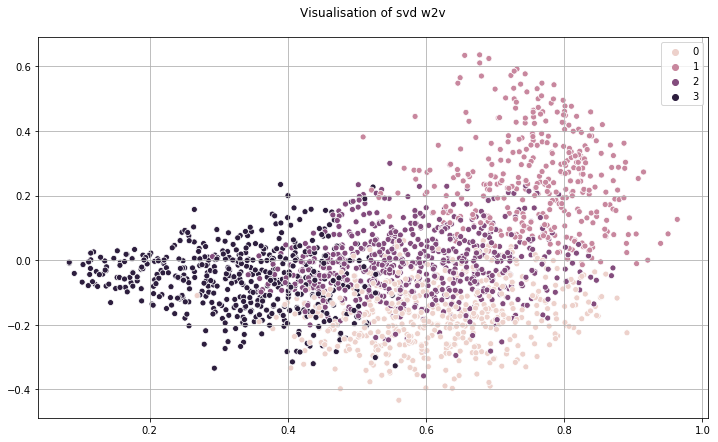

In [55]:
# visualtion of w2v vectors using SVD
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=2)
viz_w2v=svd.fit_transform(data_matrix)

plt.figure(figsize=(12,7))
sns.scatterplot(viz_w2v[:,0],viz_w2v[:,1],hue=km.predict(w2v_df),)
plt.title("Visualisation of svd w2v\n")
plt.grid()
plt.show()

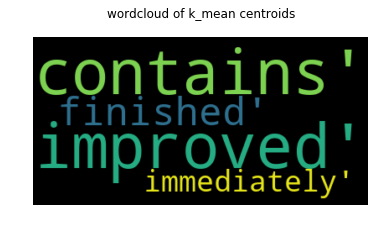

In [72]:
# wordcloud of centroids
closest_words=(pd.DataFrame(vocab).iloc[closest])
text=[]
for i in range(closest_words.shape[0]):
    text.append(closest_words.iloc[i,0])
    
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(str(text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("wordcloud of k_mean centroids\n")
plt.show()

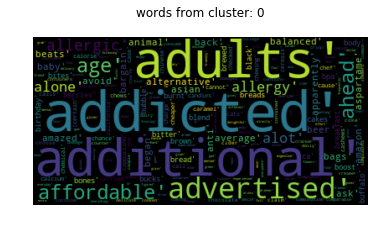

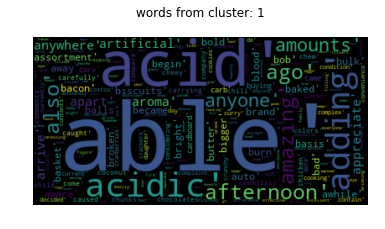

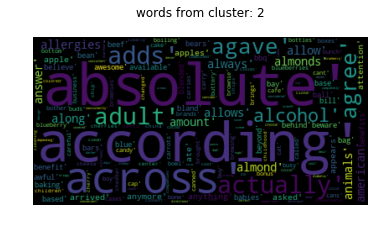

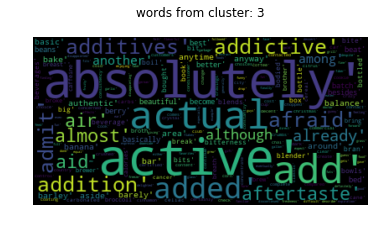

In [63]:
# wordcloud of each cluster

for i in range(optimal_k):
    words_of_cluster=(pd.DataFrame(vocab).iloc[np.argwhere(km.predict(w2v_df)==i).ravel()])

    text=[]
    for j in range(words_of_cluster.shape[0]):
        text.append(words_of_cluster.iloc[j,0])

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(str(text))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"words from cluster: {i}\n")
    plt.axis("off")
    plt.show()

### [5.6] Function that returns most similar words for a given word.

In [65]:
from sklearn.metrics import pairwise_distances
def similarity(word,n=5):
    
    word=str(word)
    
    if word in vocab: 
        p=pairwise_distances([w2v_df.loc[word]],w2v_df,metric='cosine') # calculating the distance of word vector to rest of the w2v vectors
        n_similar=p.argsort()[0][1:n+1] # finding n_closest wrd
        return w2v_df.iloc[n_similar] # n_similar words 

    else:
        print("word is not present in vocabulary")

In [66]:
# example 1
similarity("almost",10)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
basically,0.825402,-0.181606,0.038532,-0.114607,-0.066644,-0.047772,-0.026278,0.126800,-0.132216,0.127563,...,-0.003064,-0.007857,0.002293,0.006137,-0.018227,0.005428,0.002416,0.008916,-0.004093,0.005761
kind,0.849135,-0.173083,0.195220,-0.009154,-0.050181,0.144132,-0.170265,0.041302,-0.186483,0.139926,...,-0.006090,-0.005591,0.003684,0.002620,0.004864,-0.000513,0.003481,0.002538,-0.002261,-0.011335
literally,0.752694,-0.119179,-0.066270,-0.131392,0.048693,-0.008989,-0.258720,0.028824,-0.103437,0.058392,...,-0.016634,0.001371,0.009326,0.005777,0.003227,-0.005692,0.002256,0.006075,0.002049,0.001809
sort,0.711288,-0.192272,0.295974,-0.078560,-0.117986,0.083082,-0.255569,0.005504,-0.225615,0.189568,...,0.000494,-0.002138,0.009334,-0.000568,-0.007641,0.001169,0.009263,0.004289,-0.000560,-0.000020
actually,0.876532,-0.117498,0.120529,0.005948,-0.105591,0.034141,-0.134286,-0.043877,0.002749,0.089011,...,-0.011325,-0.012004,-0.007966,-0.014313,0.005658,0.009071,-0.004304,0.006726,-0.006762,0.005069
seems,0.692509,-0.317725,0.063869,-0.134758,-0.151740,0.117160,-0.217981,0.026030,-0.184625,0.253962,...,0.003270,-0.001712,0.000852,0.003305,0.002092,0.000853,0.001672,0.013448,0.002368,-0.000964
kinda,0.634450,-0.210739,0.279484,-0.080845,-0.139671,0.113576,-0.250467,-0.032708,-0.258892,0.254631,...,-0.004128,0.008569,-0.009800,0.007509,-0.006235,-0.006847,0.012987,-0.003847,0.011454,-0.017168
seemed,0.649482,-0.281664,0.086044,-0.182478,-0.131472,0.139819,-0.251933,0.000979,-0.200854,0.295982,...,0.001708,-0.003206,-0.000400,0.008591,0.007710,0.010310,0.002667,-0.001504,0.012820,-0.004616
also,0.890876,-0.224894,0.031854,-0.092708,-0.149193,0.140814,0.086981,-0.071097,0.039736,0.022206,...,-0.004658,-0.001545,0.003024,-0.001535,0.001667,0.002742,-0.004843,-0.001969,0.012192,0.000545
heaven,0.701959,-0.214136,0.149469,-0.066446,-0.019176,0.067747,-0.179626,-0.030488,-0.213150,0.212603,...,-0.017528,0.006732,0.008344,0.009825,0.003181,-0.009763,-0.008488,0.002921,-0.017396,0.008903


In [67]:
# example 2
similarity("tasty",10)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
yummy,0.852369,-0.115747,0.145373,-0.021751,-0.118296,-0.016990,-0.003852,-0.114190,0.108571,-0.037316,...,-0.008402,-0.005215,0.012647,-0.002140,0.001459,0.001078,-0.005623,-0.007169,-0.008121,-0.003104
delicious,0.838086,-0.157302,0.153023,0.108578,-0.016789,-0.017185,0.017627,-0.065522,0.088132,-0.080695,...,-0.009600,-0.002391,0.034945,0.002523,0.002117,-0.010804,-0.011590,-0.008333,-0.016719,-0.024211
filling,0.774642,-0.025540,0.176731,-0.119159,-0.115569,0.023767,0.134653,-0.156306,0.154374,0.018839,...,-0.005153,0.005840,0.012594,-0.000223,-0.001357,0.007093,-0.005370,0.005665,-0.002789,0.008587
inexpensive,0.769970,0.075470,-0.022906,0.079064,-0.072892,0.105745,0.172408,-0.060179,0.115366,-0.092204,...,0.008670,-0.002538,0.017064,0.008376,-0.001442,0.002341,0.004601,-0.015275,0.007542,-0.004422
however,0.963681,0.126049,0.041736,0.094925,-0.067802,-0.001851,-0.018793,-0.011824,0.013102,0.011681,...,0.001367,-0.001677,-0.000992,0.001745,0.002954,-0.004279,0.002631,0.002085,-0.000418,-0.001460
enjoyable,0.807316,0.036259,0.206519,0.256245,0.096912,-0.007263,-0.001262,-0.058363,0.106452,-0.107987,...,-0.006198,0.006773,0.010389,0.008542,0.001851,-0.008357,-0.003740,-0.002854,0.008560,0.016299
although,0.914826,0.272766,0.173036,0.058769,-0.019350,0.026453,0.032768,-0.020225,0.014568,-0.022872,...,0.001561,-0.002419,-0.002026,-0.006159,-0.005669,-0.003285,0.002452,0.000925,-0.001529,0.001997
satisfying,0.724109,-0.135458,0.238892,0.058484,-0.105320,-0.079049,0.013848,-0.138615,0.158616,0.003261,...,0.004459,0.005622,0.004862,-0.005086,-0.007829,-0.008749,0.009527,0.003952,0.006148,0.005557
flavorful,0.790562,0.023671,0.220680,0.164718,0.115317,0.118645,0.142937,-0.049141,0.084858,-0.008582,...,0.001635,0.000474,0.009683,-0.001499,-0.007342,-0.006994,0.011263,0.003031,0.007978,-0.006215
still,0.920914,0.000009,0.055687,0.012451,-0.095200,0.054380,0.027255,-0.111931,0.108548,0.048496,...,-0.003591,-0.002531,-0.002313,-0.003292,-0.003845,-0.000647,0.004278,-0.002746,0.000626,-0.013564


In [68]:
# example 3
print(list(similarity("good",10).index))

['like', 'awesome', 'ok', 'amazing', 'terrible', 'okay', 'impressed', 'disappointing', 'gross', 'fantastic']


In [69]:
# example 5
print(list(similarity("bad",10).index))

['know', 'realize', 'understand', 'disappointed', 'mention', 'obviously', 'stand', 'believe', 'care', 'forget']


In [70]:
# example 5
similarity("ugly",10)

word is not present in vocabulary


# [6] Conclusions

1. We have used maximum dimension(d) = 500 as it able to explain 90% of variance of dataset.


2. Word2Vec obtained by SVD is not as powerfull as gensim w2v or other state of art w2v representaion.


3. optimal number of cluster obtained is k = 4 


4. able to seperate clusters (refer: 5.4)